In [4]:
!pip install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 49.2 MB/s eta 0:00:00a 0:00:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 52.9 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


# Imports

In [37]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

# Naive modelisation
Let's try to make prediction based only on Mohamed Salah's statistics 

The idea is to predict the goals on next match given the last 5 matchs

In [11]:
def create_sequences(data, target_column, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        # Ajouter une séquence de longueur seq_length
        sequences.append(data.iloc[i:i + seq_length].drop(columns=[target_column, 'date']).values)
        # Ajouter la cible correspondante
        targets.append(data.iloc[i + seq_length][target_column])
    
    return np.array(sequences), np.array(targets)

In [12]:
# Charger les données dans un DataFrame
df = pd.read_csv("data/Mohamed Salah.csv")
df = df.sort_values(by='date').reset_index(drop=True)

# Normaliser toutes les colonnes sauf la colonne cible (goals) et la colonne date
features_to_normalize = df.drop(columns=["goals", "date"]).columns
scaler = StandardScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Créer les séquences
seq_length = 5  # Longueur des séquences
X, y = create_sequences(df, target_column="goals", seq_length=seq_length)

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Forme des données d'entraînement :", X_train.shape, y_train.shape)
print("Forme des données de test :", X_test.shape, y_test.shape)

Forme des données d'entraînement : (18, 5, 13) (18,)
Forme des données de test : (9, 5, 13) (9,)


In [9]:
# Instancier le modèle
model = LinearRegression()

# Ajuster le modèle sur les données d'entraînement
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Aplatir les séquences
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model.fit(X_train_flat, y_train)

# Prédire sur les données de test
y_pred = model.predict(X_test_flat)

# Évaluer le modèle
print("MSE (RL) :", mean_squared_error(y_test, y_pred))
print("Score R² (RL) :", r2_score(y_test, y_pred))

MSE (RL) : 0.29066356339547866
Score R² (RL) : -0.30798603527965396


### Analyse des résultats

   - Le **\( R^2 \) négatif** (-0.308) montre que le modèle fait pire qu'une prédiction basée sur la moyenne des cibles.

### Causes possibles

- **Taille des données** :
  - **27 observations** au total, réparties en **18 pour l'entraînement** et **9 pour le test**. Cette petite quantité de données rend difficile pour le modèle d'apprendre des relations significatives.

- **Problème de séquences** :
  - Chaque entrée (séquence) comporte 5 observations avec 13 caractéristiques, soit un vecteur aplati de **65 dimensions** en entrée. Avec seulement 18 échantillons d'entraînement, le modèle est susceptible de **surajuster** ou de ne pas apprendre correctement.

- **Inadéquation du modèle** :
  - Une régression linéaire n'est peut-être pas le modèle approprié pour capturer des relations temporelles ou non linéaires dans vos données.

### Amélioration possible

**Augmenter la quantité de données** :
   - Collectez plus de données pour améliorer la généralisation du modèle.

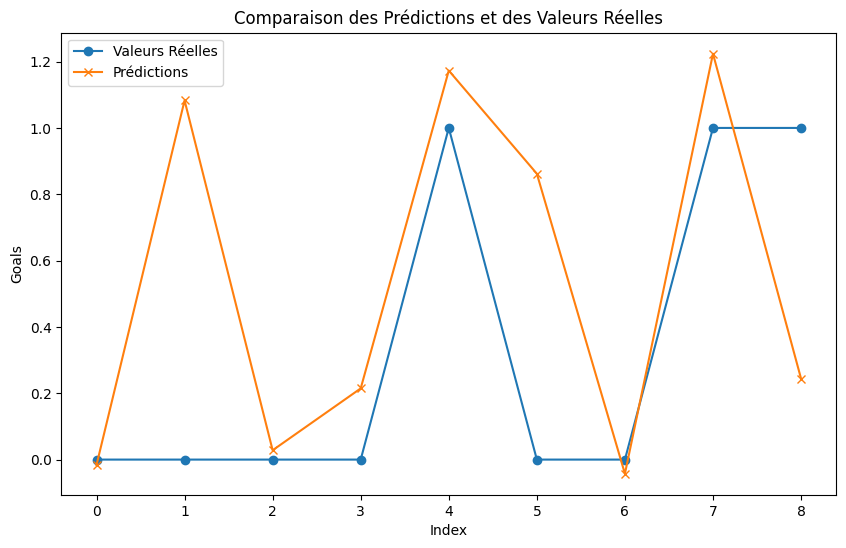

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Valeurs Réelles", marker='o')
plt.plot(y_pred, label="Prédictions", marker='x')
plt.legend()
plt.title("Comparaison des Prédictions et des Valeurs Réelles")
plt.xlabel("Index")
plt.ylabel("Goals")
plt.show()

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Applatir les séquences pour le Random Forest
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# Prédictions
y_pred_rf = rf_model.predict(X_test_flat)

# Évaluer le modèle
print("MSE (Random Forest) :", mean_squared_error(y_test, y_pred_rf))
print("R² (Random Forest) :", r2_score(y_test, y_pred_rf))


MSE (Random Forest) : 0.3292555555555555
R² (Random Forest) : -0.4816499999999999


In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Générer des caractéristiques polynomiales
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_flat)
X_test_poly = poly.transform(X_test_flat)

# Régression linéaire sur données polynomiales
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Prédictions
y_pred_poly = poly_model.predict(X_test_poly)

# Évaluer le modèle
print("MSE (Polynomial Regression) :", mean_squared_error(y_test, y_pred_poly))
print("R² (Polynomial Regression) :", r2_score(y_test, y_pred_poly))


MSE (Polynomial Regression) : 0.460150795767903
R² (Polynomial Regression) : -1.0706785809555637


# More robust modelisation

The idea is to build a more general model by providing data from different forward players

In [13]:
import os

In [20]:
path_root = 'data'
files_path = [os.path.join(path_root, file_name) for file_name in os.listdir(path_root)]

seq_length = 5
sequences = []
targets = []

for file in files_path:
    try:
        df = pd.read_csv(file)
        seq, targ = create_sequences(df, target_column="goals", seq_length=seq_length)
        
        # Vérifier que les dimensions des séquences et cibles sont compatibles
        if seq.shape[0] == targ.shape[0] and seq.ndim == 3 and targ.ndim == 1:
            if len(sequences) == 0:
                sequences = seq
                targets = targ
            else:
                sequences = np.concatenate((sequences, seq), axis=0)
                targets = np.concatenate((targets, targ), axis=0)
        else:
            print(f"Fichier ignoré : {file} - Dimensions incompatibles (seq: {seq.shape}, targ: {targ.shape})")
    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file} : {e}")

# Vérification des dimensions finales
print("Forme finale des séquences :", sequences.shape)
print("Forme finale des cibles :", targets.shape)

Fichier ignoré : data/Divin Mubama.csv - Dimensions incompatibles (seq: (0,), targ: (0,))
Forme finale des séquences : (1162, 5, 13)
Forme finale des cibles : (1162,)


1. Linear Regression

In [21]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.3, random_state=42)

print("Forme des données d'entraînement :", X_train.shape, y_train.shape)
print("Forme des données de test :", X_test.shape, y_test.shape)


Forme des données d'entraînement : (813, 5, 13) (813,)
Forme des données de test : (349, 5, 13) (349,)


In [23]:
# Aplatir les séquences pour RL et RF
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("Forme des données aplaties pour RL et RF :", X_train_flat.shape, X_test_flat.shape)


Forme des données aplaties pour RL et RF : (813, 65) (349, 65)


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Entraîner le modèle
model_rl = LinearRegression()
model_rl.fit(X_train_flat, y_train)

# Prédictions
y_pred_rl = model_rl.predict(X_test_flat)

# Évaluation
print("MSE (RL):", mean_squared_error(y_test, y_pred_rl))
print("R² (RL):", r2_score(y_test, y_pred_rl))


MSE (RL): 0.35108837963574163
R² (RL): -0.036676744921526394


In [25]:
from sklearn.ensemble import RandomForestRegressor

# Entraîner le modèle
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_flat, y_train)

# Prédictions
y_pred_rf = model_rf.predict(X_test_flat)

# Évaluation
print("MSE (RF):", mean_squared_error(y_test, y_pred_rf))
print("R² (RF):", r2_score(y_test, y_pred_rf))


MSE (RF): 0.35304126074498565
R² (RF): -0.04244311757575736


In [38]:
!pip install tensorflow


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-24.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached protobuf-5.29.2-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Usin

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Construire le modèle LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Sortie pour une seule prédiction
])

# Compiler le modèle
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Entraîner le modèle
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

# Prédictions
y_pred_lstm = model_lstm.predict(X_test).flatten()

# Évaluation
print("MSE (LSTM):", mean_squared_error(y_test, y_pred_lstm))
print("R² (LSTM):", r2_score(y_test, y_pred_lstm))


ModuleNotFoundError: No module named 'tensorflow'

In [41]:
!which python

/Users/mounir/Desktop/Premier-League-Simulation/.venv/bin/python
